In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
np.random.seed(12345)

In [3]:
dataset = 'detailed'
feature = 'range_value'

In [4]:
def plot_feature_target(dataset, feature, transform_dict, transform_lower, transform_upper, saveplot=False):
    # Load data
    features_df = pd.read_csv('data/' + dataset + '/features.csv')
    feature_df = features_df[feature]
    target_df = pd.read_csv('data/' + dataset + '/target.csv')

    # Apply transformation
    x_lower = transform_dict[transform_lower](feature_df.to_numpy().reshape(-1, 1))
    x_upper = transform_dict[transform_upper](feature_df.to_numpy().reshape(-1, 1))
    y1 = target_df['min.log.lambda'].to_numpy()
    y2 = target_df['max.log.lambda'].to_numpy()

    # Randomly sample indices
    num_samples = 200
    if target_df.shape[0] < 200:
        num_samples = target_df.shape[0]
    indices = np.random.choice(len(x_lower), num_samples, replace=False)

    # Select samples
    x_lower_sampled = x_lower[indices]
    x_upper_sampled = x_upper[indices]
    y1_sampled = y1[indices]
    y2_sampled = y2[indices]

    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

    # Plot (x, y1)
    ax1.plot(x_lower_sampled, y1_sampled, 'o', markeredgecolor='black', markerfacecolor='none')
    ax1.set_xlabel("x = " + transform_lower + '(' + feature + ')')
    ax1.set_ylabel('y = lower target')
    ax1.set_title('Lower Bounds')
    ax1.grid(True)

    # Plot (x, y2)
    ax2.plot(x_upper_sampled, y2_sampled, 'o', markeredgecolor='black', markerfacecolor='black')
    ax2.set_xlabel("x = " + transform_upper + '(' + feature + ')')
    ax2.set_ylabel('y = upper target')
    ax2.set_title('Upper Bounds')
    ax2.grid(True)

    plt.suptitle(dataset + " --- " + feature)
    plt.tight_layout()
    if(saveplot == True):
        plt.savefig("figs/" + dataset + "." + feature + "." + transform_lower + "." + transform_upper + ".png")
    plt.show()

In [5]:
# Define the model function
def model(x, w1, w2, beta):
    return w1 * x**w2 + beta

x_lower_data  = pd.read_csv('data/' + dataset + '/features.csv')[feature]
y1_data = pd.read_csv('data/' + dataset + '/target.csv')['min.log.lambda']

# Apply the mask to both x_lower_data and y1_data
mask = y1_data != -np.inf
x_lower_data = x_lower_data[mask]
y1_data = y1_data[mask]


x_upper_data = pd.read_csv('data/' + dataset + '/features.csv')[feature]
y2_data = pd.read_csv('data/' + dataset + '/target.csv')['max.log.lambda']

# Apply the mask to both x_upper_data and y2_data
mask = y2_data != np.inf
x_upper_data = x_upper_data[mask]
y2_data = y2_data[mask]

# Fit the model to the data
popt_lower, _ = curve_fit(model, x_lower_data, y1_data, p0 = [1, 0.1, 0.1], maxfev = 5000)
popt_upper, _ = curve_fit(model, x_upper_data, y2_data, p0 = [1, 0.1, 0.1], maxfev = 5000)

# print parameters
print(popt_lower, popt_upper)

[ 1.67326713e+04  9.87779252e-05 -1.67340334e+04] [ 1.41911351e+04  1.11097030e-04 -1.41899117e+04]


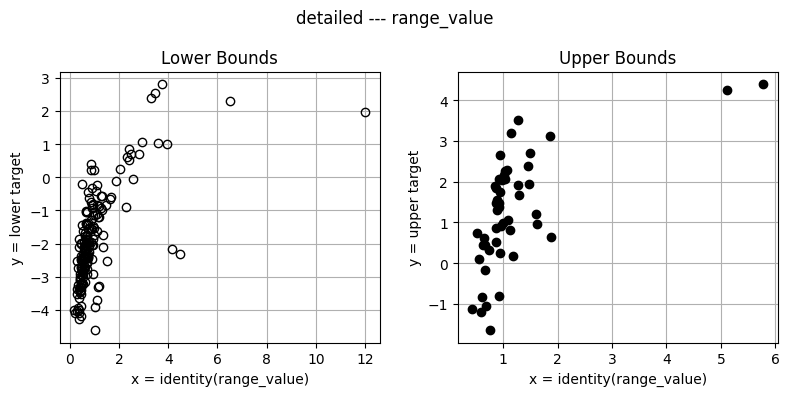

In [6]:
identity  = lambda x: x
log       = lambda x: np.log(x)
loglog    = lambda x: np.log(np.log(x))
logloglog = lambda x: np.log(np.log(np.log(x)))
sqrt      = lambda x: np.sqrt(x)
cbrt      = lambda x: np.cbrt(x)

transform_dict = {
    "identity": identity,
    "log": log,
    "loglog": loglog,
    "logloglog": logloglog,
    "sqrt": sqrt,
    "cbrt": cbrt
}

plot_feature_target('detailed', 'range_value', transform_dict, 'identity', 'identity', saveplot=True)

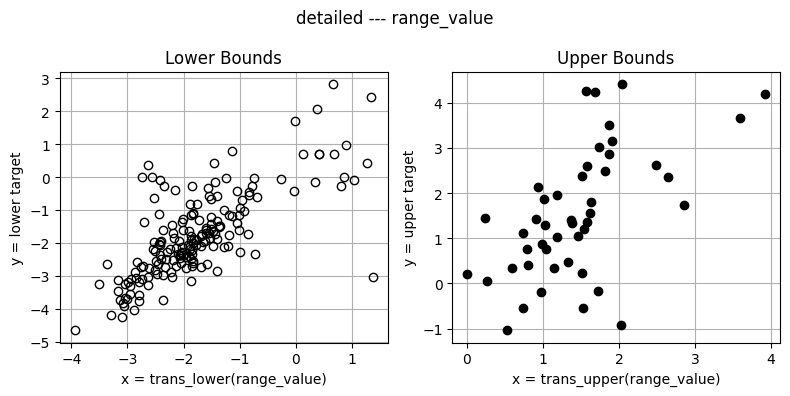

In [7]:
# create dictionary
lower_trans_func  = lambda x: model(x, *popt_lower)
upper_trans_func  = lambda x: model(x, *popt_upper)

power_transform_dict = {
    "trans_lower": lower_trans_func,
    "trans_upper": upper_trans_func
}

plot_feature_target('detailed', 'range_value', power_transform_dict, 'trans_lower', 'trans_upper', saveplot=True)